# Deep Q-Learning

适用场景：离散动作空间
原因：因为Q-learning方法就是使用神经网络去拟合Q-value，也就是使用神经网络给出当前状态下，采取的各个动作的Q值，因此动作一定是离散的

神经网络：
- input：当前状态
- output：在当前状态下，所有动作所对应的Q-value



In [15]:
import torch
import torch.optim as optim
import gymnasium as gym
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

def epsilon_greedy(q_values, epsilon):
    if torch.rand(1).item() < epsilon:
        return random.randint(0, len(q_values) - 1)
    else:
        return torch.argmax(q_values).item()

env = gym.make('CartPole-v1')
dqn = DQN(env.observation_space.shape[0], env.action_space.n)
target_dqn = DQN(env.observation_space.shape[0], env.action_space.n)
target_dqn.load_state_dict(dqn.state_dict())
target_dqn.eval()

optimizer = optim.Adam(dqn.parameters(), lr=0.001)
replay_buffer = ReplayBuffer(10000)
gamma = 0.99
epsilon = 0.3
batch_size = 64
target_update_freq = 10
episodes = 1000

for episode in range(episodes):
    observation, info = env.reset()
    done = False
    truncated = False
    total_reward = 0
    
    while not done and not truncated:
        q_values = dqn(torch.tensor(observation, dtype=torch.float32))
        action = epsilon_greedy(q_values, epsilon)
        next_observation, reward, done, truncated, info = env.step(action)
        
        replay_buffer.push(observation, action, reward, next_observation, done)
        observation = next_observation
        total_reward += reward
        
        if len(replay_buffer) > batch_size:
            batch = replay_buffer.sample(batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.tensor(states, dtype=torch.float32)
            actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
            rewards = torch.tensor(rewards, dtype=torch.float32)
            next_states = torch.tensor(next_states, dtype=torch.float32)
            dones = torch.tensor(dones, dtype=torch.float32)
            
            q_values = dqn(states).gather(1, actions).squeeze(1)
            with torch.no_grad():
                max_next_q_values = target_dqn(next_states).max(1)[0]
                targets = rewards + (1 - dones) * gamma * max_next_q_values
            
            loss = F.mse_loss(q_values, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    if episode % target_update_freq == 0:
        target_dqn.load_state_dict(dqn.state_dict())
    
    print(f"Episode: {episode + 1}, Reward: {total_reward}")

env.close()

Episode: 1, Reward: 119.0
Episode: 2, Reward: 9.0
Episode: 3, Reward: 12.0
Episode: 4, Reward: 9.0
Episode: 5, Reward: 8.0
Episode: 6, Reward: 10.0
Episode: 7, Reward: 9.0
Episode: 8, Reward: 12.0
Episode: 9, Reward: 11.0
Episode: 10, Reward: 11.0
Episode: 11, Reward: 11.0
Episode: 12, Reward: 8.0
Episode: 13, Reward: 21.0
Episode: 14, Reward: 13.0
Episode: 15, Reward: 14.0
Episode: 16, Reward: 10.0
Episode: 17, Reward: 12.0
Episode: 18, Reward: 22.0
Episode: 19, Reward: 10.0
Episode: 20, Reward: 12.0
Episode: 21, Reward: 12.0
Episode: 22, Reward: 13.0
Episode: 23, Reward: 17.0
Episode: 24, Reward: 15.0
Episode: 25, Reward: 10.0
Episode: 26, Reward: 14.0
Episode: 27, Reward: 13.0
Episode: 28, Reward: 12.0
Episode: 29, Reward: 14.0
Episode: 30, Reward: 13.0
Episode: 31, Reward: 15.0
Episode: 32, Reward: 13.0
Episode: 33, Reward: 18.0
Episode: 34, Reward: 12.0
Episode: 35, Reward: 27.0
Episode: 36, Reward: 12.0
Episode: 37, Reward: 34.0
Episode: 38, Reward: 11.0
Episode: 39, Reward: 10.0

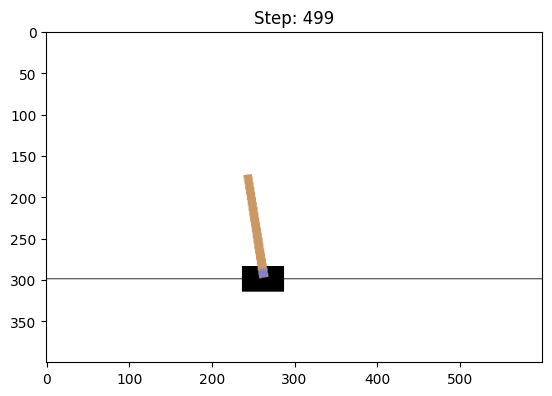

reached max steps
Total steps: 500


In [16]:

import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output

env = gym.make('CartPole-v1', render_mode='rgb_array')
env.reset()
done = False
truncated = False
step = 0
while not done and truncated == False:
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.title(f"Step: {step}")
    plt.show()
    q_values = dqn(torch.tensor(observation, dtype=torch.float32))
    action = torch.argmax(q_values).item()
    observation, reward, done, truncated, info = env.step(action)
    step += 1

    if step == 500:
        print("reached max steps")
env.close()

print(f"Total steps: {step}")